In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython import display
import datetime
import time
from utils import *

from deep_shadow import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading dataset

In [3]:
cities = ['nyc']
dates = ['summer']

zoom = 16
shadow_path = 'data/shadows/'
height_path = 'data/heights_new/'

TILES_PER_CITY = 200
BATCH_SIZE = 1

In [45]:
train_dataset, test_dataset = get_train_test(
        height_path, shadow_path, cities, dates, zoom, TILES_PER_CITY, BATCH_SIZE)

### Latitude and date inclusion

In [ ]:
lat, dat = False, False

### Store Model Results

In [24]:
def store_result(checkpoint_name, deep_shadow, test_dataset, lat, dat):
    df = pd.read_csv('data/compare_models/results.csv')
    rmses, maes, mses, ssims, sobels = get_metrics(test_dataset, deep_shadow.generator, latitude=lat, date=dat)
    df.loc[len(df.index)] = [checkpoint_name, np.average(maes), np.average(mses), np.average(rmses), np.average(ssims), np.average(sobels)] 
    df.to_csv('data/compare_models/results.csv', index=False)

    # print('MAE: %.4f' % np.average(maes), 'MSE: %.4f' % np.average(mses), 'RMSE: %.4f' % np.average(rmses), 'SSIM: %.4f' % np.average(ssims), 'Sobel: %.4f' % np.average(sobels))

    return

### Train model with different generator architectures and w or w/o attention

In [53]:
checkpoint_names = ['_resnet_wo_attn', '_resnet_w_attn_specnorm', '_unet_wo_attn', '_unet_w_attn_specnorm']

gen_types = ['resnet9', 'resnet9', 'unet', 'unet']

attn = [False, True, False, True]

loss_function = [l1_loss]

for i in range(len(checkpoint_names)):
    tf.keras.backend.clear_session()

    down_stack, up_stack = get_generator_arch(gen_types[i], attn=attn[i])
     
    train_dataset, test_dataset = get_train_test(
        height_path, shadow_path, cities, dates, zoom, TILES_PER_CITY, BATCH_SIZE, ignore_images = path_list)
    
    checkpoint_name = 'test' + checkpoint_names[i]
    checkpoint_path = 'training_checkpoints/%s' % (checkpoint_name)
    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=lat, date=dat, loss_funcs=loss_function, type=gen_types[i], attention=attn[i], model_name=checkpoint_name)
    deep_shadow.fit(checkpoint_path, train_dataset, test_dataset, 40000)

    deep_shadow.restore(checkpoint_path)
    store_result(checkpoint_name, deep_shadow, test_dataset, lat, dat)

### Load model

In [ ]:
tf.keras.backend.clear_session()
down_stack, up_stack = get_generator_arch('resnet9', attn=False)
deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=[ssim_loss, l1_loss], type='resnet9', attention=False, weighted_loss=False, model_name=checkpoint_name)
deep_shadow.restore('training_checkpoints_new/uniform_cities_resnet_wo_attn__ssim_l1')

### Test on one image

mae: 0.058069 mse: 0.009840 rmse: 0.099198 ssim: 0.851631


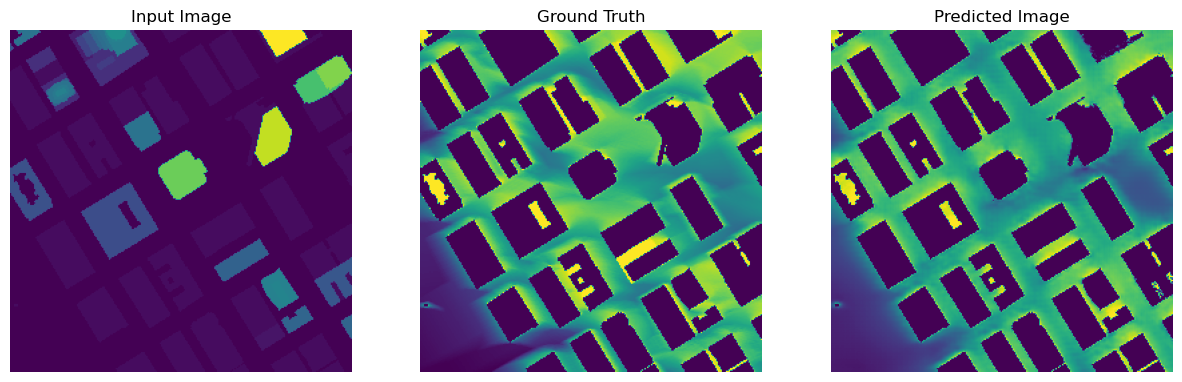

In [82]:
city, date, zoom = 'sea', 'summer', 16
i, j = 10497, 22888
test_on_image(deep_shadow.generator, 'data/heights_new/', 'data/shadows/', city, date, 16, i, j, lat=True, dat=True)